**main script**
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [ ]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

# Deterministic Full Waveform Inversion

In [1]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import tensorflow as tf
import tensorflow_probability as tfp
print('GPU:',tf.config.list_physical_devices('GPU'))
from func.propagation_tf import simulate_obs

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import cupy as cp
device = 'cpu'

## Tensorflow mapping function
# def f_tf(u, vmin=2000, vmax=3000):
#     cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
#     # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
#     v = (vmax - vmin) * cdf + vmin
#     return v

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v

# def f(u, a=2000, b=3000):
# 	'''
# 	Reparametrization mapping function from u -> v
# 	Unconstrained parameter -> Physical parameter space
# 	'''
# 	v = a+(b-a)/(1+np.exp(-u))

# 	return v


def f_inv(v, a=2000, b=3000):
	'''Inverse of the mapping function f^-1'''
	u = np.log(v-a) - np.log(b-v)

	return u


# Define cost function
def loglik_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
 
	return tf.cast(log_likelihood, tf.float32)

# Calculate gradient with Adjoint state method
def dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)
	dloglik_dv = -dJ_dv / alpha
	dv_du = sc.misc.derivative(f,u)

	return tf.cast(dloglik_dv.flatten() * dv_du.flatten(), tf.float32)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Forward modeling

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 104


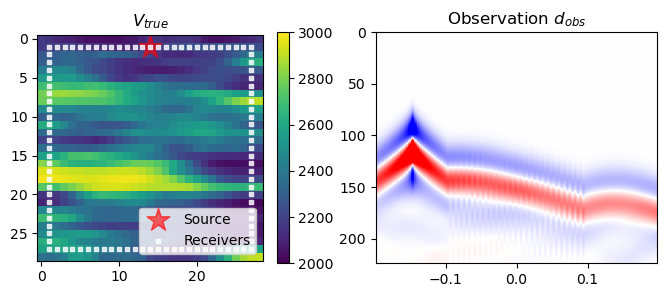

In [2]:
# Model size (nz,nx) = (29,29)
import pickle
# load data
filename = './data/u_29'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_29'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [1], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
u_ref = u_ref.flatten()
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx-1,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
# zxrec = zxrec1
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# d_obs = simulate_obs(f(u_ref).resh, wsrc, zxsrc, at, az, ax, next, zxrec)
p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800
Number of receivers: 156


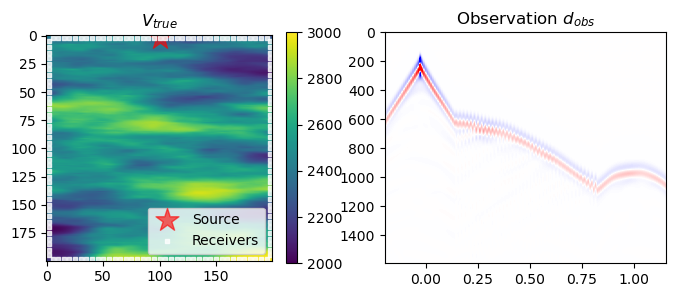

In [4]:
# Model size (nz,nx) = (200,200)

import pickle
# load data
filename = './data/u_200'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_200'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)

p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

## Inversion with prior regularization term

In [4]:
# # load FWI result
# filename = './data/u_200_fwi'
# infile = open(filename, 'rb')
# u_fwi = pickle.load(infile)
# infile.close()

# u_fwi = u_fwi.flatten()
# u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
# v_init = f(u_init)   # Initial v
# std_noise = 0.1

In [5]:
# Define cost function
def objective_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u = u.flatten()
	penalty = .5 * u.T.dot(Q.toarray()).dot(u) * alpha
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

# Calculate gradient with Adjoint state method
def gradiant_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()*sc.misc.derivative(f,u).flatten() + Q.toarray().dot(u.flatten()) * alpha

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	
# minimize cost function
start = time.time()
u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.1 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = objective_fwi_prior, 
               x0 = u_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant_fwi_prior,
               options = {'disp':True, 'maxiter':150},
               callback=callback
              )
u_fwi = resi.x
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

Loss (J) = 5219.8787 Penalty term = 0.0000 Total loss = 5219.8787 


C:\Users\lenovo\AppData\Local\Temp\ipykernel_2284\2771189260.py:41: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return G.flatten()*sc.misc.derivative(f,u).flatten() + Q.toarray().dot(u.flatten()) * alpha


Loss (J) = 4351.9518 Penalty term = 0.0024 Total loss = 4351.9543 
Loss (J) = 1810.6726 Penalty term = 0.0607 Total loss = 1810.7332 
Loss (J) = 595.0816 Penalty term = 0.2519 Total loss = 595.3335 
Loss (J) = 457.0142 Penalty term = 0.3136 Total loss = 457.3278 
Loss (J) = 183.2756 Penalty term = 0.4445 Total loss = 183.7200 
Loss (J) = 122.8897 Penalty term = 0.4329 Total loss = 123.3226 
Loss (J) = 65.8208 Penalty term = 0.3852 Total loss = 66.2061 
Loss (J) = 47.5248 Penalty term = 0.3463 Total loss = 47.8712 
Loss (J) = 32.7928 Penalty term = 0.2979 Total loss = 33.0907 
Loss (J) = 25.3578 Penalty term = 0.2616 Total loss = 25.6194 
Loss (J) = 18.4205 Penalty term = 0.2154 Total loss = 18.6359 
Loss (J) = 16.3404 Penalty term = 0.2007 Total loss = 16.5411 
Loss (J) = 13.8381 Penalty term = 0.2036 Total loss = 14.0417 
Loss (J) = 11.4489 Penalty term = 0.2070 Total loss = 11.6559 
Loss (J) = 10.4266 Penalty term = 0.1999 Total loss = 10.6265 
Loss (J) = 9.0618 Penalty term = 0.1991

## FWI result

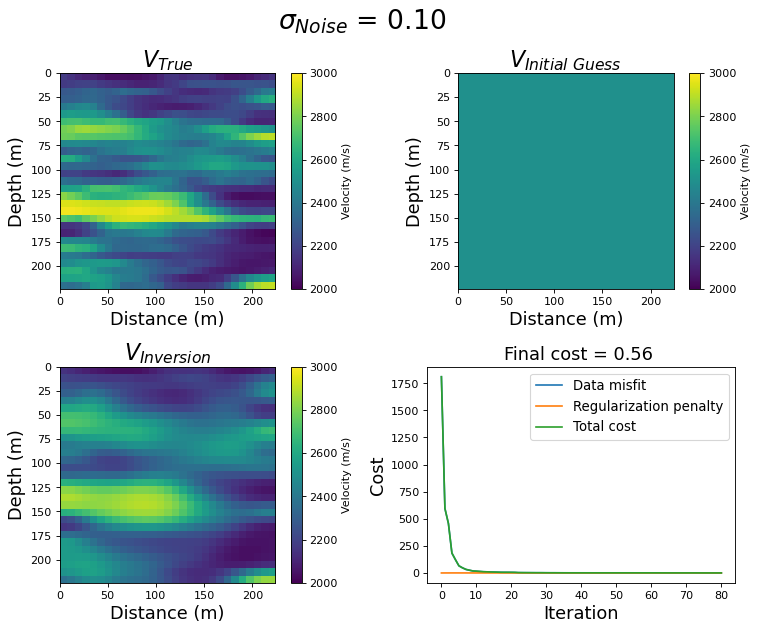

In [6]:
# Plot deterministic FWI result and optimization history
v_fwi = f(u_fwi)

plt.figure(figsize=(10,8),dpi=80)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)
plt.subplot(2,2,2) 
plt.imshow(v_init.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.subplot(2,2,3)
plt.imshow(v_fwi.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)
plt.subplot(2,2,4)
plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Data misfit")
plt.plot(loss_tracker[:,2],label="Regularization penalty")
plt.plot(loss_tracker[:,0],label="Total cost")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,800)
plt.legend(fontsize=labelsize-4)
plt.tight_layout()
plt.show()

# 1 - Mean-field Estimation

In [56]:
import multiprocessing
args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

def compute_loglik_fn(u):
    # your implementation of loglik_fn here
    return loglik_fn(u.numpy(),d_obs,*args)
    # return -0

def compute_dloglik_du_fn(u):
    # your implementation of dloglik_du_fn here
    return dloglik_du_fn(u.numpy(),d_obs,*args)

def compute_parallel(u_samples, num_processes=4):
    with multiprocessing.Pool(processes=num_processes) as pool:
        log_likelihoods = pool.map(compute_loglik_fn, u_samples)
        grads_log_likelihoods = pool.map(compute_dloglik_du_fn, u_samples)
    return log_likelihoods, grads_log_likelihoods

# Define the prior distribution for the model parameters
prior_mean = tf.zeros(nz*nx, dtype=tf.float32)
prior_cov = tf.cast(sc.sparse.linalg.inv(Q).toarray(), tf.float32)
prior_scale_tril = tf.cast(tf.linalg.cholesky(prior_cov), tf.float32)
p_dist = tfp.distributions.MultivariateNormalTriL(loc=prior_mean, scale_tril=prior_scale_tril)
prior_scale = p_dist.stddev()

# Define the TensorFlow variables for the variational posterior mean and scale
q_mean = tf.Variable(prior_mean, dtype=tf.float32) # Set prior mean as the Variational initial mean 

# Use Transformed Variable to ensure that the variable remains positive during optimization.
q_scale_init = prior_scale
q_scale = tfp.util.TransformedVariable(q_scale_init, tfp.bijectors.Exp(), trainable=True)

# Set up lists to store progress
neg_loglik_history = []
kl_history = []
neg_elbo_history = []

optimizer = tf.keras.optimizers.Adam()

In [58]:
# Set hyper-parameters
num_samples = 100
std_noise = 1
optimizer.learning_rate = 0.1
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")

# Train the variational posterior using the ELBO objective
num_iters = 100

for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}")
    annealing_factor = tf.cast(1, tf.float32)
    
    with tf.GradientTape() as tape:
        # Watch the parameters of the variational posterior
        tape.watch([q_mean, q_scale])
        
        # Sample from the variational posterior
        q_dist = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)
        
        # Compute the log(d_obs|v) log-likelihood and its gradient
        log_likelihoods = []
        grads_log_likelihoods = []
            
        # Compute the gradient of u with respect to q_mean and q_scal
        with tf.GradientTape() as tape2:
            tape2.watch([q_mean, q_scale.trainable_variables[0]])
            u_samples = q_dist.sample(num_samples)
            du_dq = tape2.gradient(u_samples, [q_mean, q_scale.trainable_variables[0]])
        
        # ## Calculate the gradient of likelihoods with loop
        # for u in u_samples:
        #     # log_likelihoods.append(loglik_fn(u.numpy(),d_obs,*args))
        #     log_likelihoods.append(0)
        #     grads_log_likelihoods.append(dloglik_du_fn(u.numpy(),d_obs,*args))

        # Compute the gradient of likelihoods in parallel
        log_likelihoods, grads_log_likelihoods = compute_parallel(u_samples, num_processes=8)
        
        # Compute log likelihoods and grad of log-likelihoods
        E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
        grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq, dtype=tf.float32)
        grads_E_log_likelihoods = tf.unstack(grads_E_log_likelihoods, axis=0)

        # Compute the KL(q||p) term 
        kl_divergence_q_p = annealing_factor * tfp.distributions.kl_divergence(q_dist, p_dist)
        grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, [q_mean, q_scale.trainable_variables[0]])
        
        # Compute negative ELBO (to minimize)
        neg_elbo = -E_log_likelihoods + kl_divergence_q_p
        
        # Print and save the values of the neg-log-likelihood, KL(q||p), and negative ELBO
        print(f"Neg log p(dobs|v): {-E_log_likelihoods.numpy():.4f}  KL(q||p): {kl_divergence_q_p.numpy():.4f}  Neg ELBO: {neg_elbo.numpy():.4f}")
        neg_loglik_history.append(-E_log_likelihoods.numpy())
        kl_history.append(kl_divergence_q_p.numpy())
        neg_elbo_history.append(neg_elbo.numpy())

    # Compute gradients of the negative ELBO with respect to q_mean and q_scale
    grad1 = [-g for g in grads_E_log_likelihoods]
    grad2 = [g if g is not None else 0 for g in grads_kl_divergence_q_p]
    grads = [g1 + g2 for g1, g2 in zip(grad1, grad2)]
    optimizer.apply_gradients(zip(grads, [q_mean, q_scale.trainable_variables[0]]))

Learning Rate: 0.10000000149011612
Iteration 1/100
Neg log p(dobs|v): 3194.6619  KL(q||p): 36710.0312  Neg ELBO: 39904.6914
Iteration 2/100
Neg log p(dobs|v): 2607.5154  KL(q||p): 30974.4570  Neg ELBO: 33581.9727
Iteration 3/100
Neg log p(dobs|v): 2150.2334  KL(q||p): 26242.0117  Neg ELBO: 28392.2461
Iteration 4/100
Neg log p(dobs|v): 1656.0436  KL(q||p): 22339.6719  Neg ELBO: 23995.7148
Iteration 5/100
Neg log p(dobs|v): 1404.6088  KL(q||p): 19144.0176  Neg ELBO: 20548.6270
Iteration 6/100
Neg log p(dobs|v): 1182.0916  KL(q||p): 16503.8457  Neg ELBO: 17685.9375
Iteration 7/100
Neg log p(dobs|v): 983.2740  KL(q||p): 14317.4199  Neg ELBO: 15300.6943
Iteration 8/100
Neg log p(dobs|v): 871.8244  KL(q||p): 12502.0176  Neg ELBO: 13373.8418
Iteration 9/100
Neg log p(dobs|v): 765.6814  KL(q||p): 10983.6143  Neg ELBO: 11749.2959
Iteration 10/100
Neg log p(dobs|v): 724.7932  KL(q||p): 9711.2490  Neg ELBO: 10436.0420
Iteration 11/100
Neg log p(dobs|v): 697.0443  KL(q||p): 8638.8027  Neg ELBO: 93

# 2 - Full Covariance

In [ ]:
# Define the number of samples for the variational posterior
num_samples = 10

# Define the prior distribution for the model parameters
std_noise = std_noise
prior_mean = tf.zeros(nz*nx, dtype=tf.float32)
prior_cov = sc.sparse.linalg.inv(Q).toarray()
prior_cov = tf.cast(prior_cov, tf.float32)
p_dist = tfp.distributions.MultivariateNormalFullCovariance(loc=prior_mean, covariance_matrix=prior_cov)

# Define the TensorFlow variables for the variational posterior mean and covariance
q_mean = tf.Variable(prior_mean, dtype=tf.float32)
q_cov_init = tf.Variable(prior_cov, dtype=tf.float32)
# q_cov_bij = tfp.util.TransformedVariable(q_cov_init, tfp.bijectors.Exp(),
#                                       dtype=tf.float32, trainable=True)
m = tf.Variable(tf.math.log(q_cov_init), dtype=tf.float32) # Set non-constrained bijector m
q_cov = tf.exp(m)

# Set up lists to store progress
neg_loglik_history = []
kl_history = []
neg_elbo_history = []

optimizer = tf.keras.optimizers.Adam()

# Set the learning rate for the optimizer
optimizer.learning_rate = 0.1
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")
args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Train the variational posterior using the ELBO objective
num_iters = 1
for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}")
    annealing_factor = tf.cast(1, tf.float32)
    
    with tf.GradientTape() as tape:
        # Watch the parameters of the variational posterior
        tape.watch([q_mean, m])
        # Compute the log(d_obs|v) log-likelihood and its gradient
        log_likelihoods = []
        grads_log_likelihoods = []
            
        # Compute the gradient of u with respect to q_mean and q_cov
        with tf.GradientTape() as tape2:
            tape2.watch([q_mean, m])
            # q_dist = tfp.distributions.MultivariateNormalFullCovariance(loc=q_mean, covariance_matrix=q_cov)
            ''''''
            q_cov = tf.exp(m)
            q_tril = tf.linalg.cholesky(q_cov)
            q_dist = tfp.distributions.MultivariateNormalTriL(loc=q_mean, scale_tril=q_tril)
            ''''''
            u_samples = q_dist.sample(num_samples)
            du_dq = tape2.gradient(u_samples, [q_mean, m])
        
        for u in u_samples:
            log_likelihoods.append(loglik_fn(u.numpy(),d_obs,*args))
            grads_log_likelihoods.append(dloglik_du_fn(u.numpy(),d_obs,*args))
        
        # Compute log likelihoods and grad of log-likelihoods
        E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
        # grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq, dtype=tf.float32)
        du_dm = du_dq[1]
        dm_dcov = 1/q_cov
        du_dcov = du_dm * dm_dcov
        grads_E_log_likelihoods = [tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq[0], 
                                   tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dcov]
        # grads_E_log_likelihoods = tf.unstack(grads_E_log_likelihoods, axis=0)
        
        # Compute the KL(q||p) term 
        kl_divergence_q_p = annealing_factor * tfp.distributions.kl_divergence(q_dist, p_dist)
        grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, [q_mean, m])
        
        # Compute negative ELBO (to minimize)
        neg_elbo = -E_log_likelihoods + kl_divergence_q_p

        # Print and save the values of the neg-log-likelihood, KL(q||p), and negative ELBO
        print(f"Neg log p(dobs|v): {-E_log_likelihoods.numpy():.4f}  KL(q||p): {kl_divergence_q_p.numpy():.4f}  Neg ELBO: {neg_elbo.numpy():.4f}")
        neg_loglik_history.append(-E_log_likelihoods.numpy())
        kl_history.append(kl_divergence_q_p.numpy())
        neg_elbo_history.append(neg_elbo.numpy())

    # Compute gradients of the negative ELBO with respect to q_mean and q_scale
    # and apply them to the optimizer
    # grads = [-g for g in grads_E_log_likelihoods] + \
    #         [g if g is not None else 0 for g in grads_kl_divergence_q_p]
    grad1 = [-g for g in grads_E_log_likelihoods]
    grad2 = [g if g is not None else 0 for g in grads_kl_divergence_q_p]
    grads = [g1 + g2 for g1, g2 in zip(grad1, grad2)]
    optimizer.apply_gradients(zip(grads, [q_mean, m]))


# 3 - Cholesky decomposition

In [7]:
# New code here \

# Define the prior distribution for the model parameters
std_noise = 0.1
prior_mean = tf.zeros(nz*nx, dtype=tf.float32)
prior_cov = tf.cast(sc.sparse.linalg.inv(Q).toarray(), tf.float32)
prior_scale_tril = tf.cast(tf.linalg.cholesky(prior_cov), tf.float32)
p_dist = tfp.distributions.MultivariateNormalTriL(loc=prior_mean, scale_tril=prior_scale_tril)

# Define the TensorFlow variables for the variational posterior mean and scale
q_mean = tf.Variable(prior_mean, dtype=tf.float32)  # Set prior mean as the Variational initial mean 
L_init = tf.linalg.cholesky(prior_cov)
L = tfp.util.TransformedVariable(L_init, tfp.bijectors.FillTriangular(), trainable=True)
q_cov = tf.matmul(L, L, transpose_b=True)

# Set up lists to store progress
neg_loglik_history = []
kl_history = []
neg_elbo_history = []

optimizer = tf.keras.optimizers.Adam()

In [13]:
# Define the number of samples for the variational posterior
num_samples = 10
# Set the learning rate for the optimizer
optimizer.learning_rate = 0.1
std_noise = 0.1
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")
args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Train the variational posterior using the ELBO objective
num_iters = 500
for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}")
    annealing_factor = tf.cast(1, tf.float32)
    
    with tf.GradientTape() as tape:
        # Watch the parameters of the variational posterior
        tape.watch([q_mean, L.trainable_variables[0]])
        
        q_dist = tfp.distributions.MultivariateNormalTriL(loc=q_mean, scale_tril=L)
        # Compute the log(d_obs|v) log-likelihood and its gradient
        log_likelihoods = []
        grads_log_likelihoods = []
            
        # Compute the gradient of u with respect to q_mean and q_scale_tril
        with tf.GradientTape() as tape2:
            tape2.watch([q_mean, L.trainable_variables[0]])
            # Sample from the variational posterior
            u_samples = q_dist.sample(num_samples)
            du_dq = tape2.gradient(u_samples, [q_mean, L.trainable_variables[0]])
            du_dm = tfp.bijectors.FillTriangular().forward(du_dq[1])
            du_dq[1] = tf.matmul(du_dm, du_dm, transpose_b=True)
            du_dq[1] = du_dm
        
        for u in u_samples:
            log_likelihoods.append(loglik_fn(u.numpy(),d_obs,*args))
            grads_log_likelihoods.append(dloglik_du_fn(u.numpy(),d_obs,*args))

        #################################################################################
        # Compute log likelihoods and grad of log-likelihoods
        E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
        grads_E_log_likelihoods = [tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq[0],
                                   tfp.bijectors.FillTriangular().inverse(tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq[1])]
        # grads_E_log_likelihoods = [tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq[0],
        #                            tfp.bijectors.FillTriangular().inverse(tf.linalg.diag(tf.reduce_mean(grads_log_likelihoods,axis=0))) * du_dq[1]]

        # Compute the KL(q||p) term 
        kl_divergence_q_p = 0*tfp.distributions.kl_divergence(q_dist, p_dist)
        grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, [q_mean, L.trainable_variables[0]])
                                                                    
        # Compute negative ELBO (to minimize)
        neg_elbo = -E_log_likelihoods + kl_divergence_q_p
        
        # Print and save the values of the neg-log-likelihood, KL(q||p), and negative ELBO
        print(f"Neg log p(dobs|v): {-E_log_likelihoods.numpy():.4f}  KL(q||p): {kl_divergence_q_p.numpy():.4f}  Neg ELBO: {neg_elbo.numpy():.4f}")
        neg_loglik_history.append(-E_log_likelihoods.numpy())
        kl_history.append(kl_divergence_q_p.numpy())
        neg_elbo_history.append(neg_elbo.numpy())

    # Compute gradients of the negative ELBO with respect to q_mean and q_scale
    grad1 = [-g for g in grads_E_log_likelihoods]
    grad2 = grads_kl_divergence_q_p
    # grad2 = [g if g is not None else 0 for g in grads_kl_divergence_q_p]
    grads = [g1 + g2 for g1, g2 in zip(grad1, grad2)]
    optimizer.apply_gradients(zip(grads, [q_mean, L.trainable_variables[0]]))

    # if i%100==99: 
    #     optimizer.learning_rate = optimizer.learning_rate * 0.1
    #     print(f"Learning Rate: {optimizer.learning_rate.numpy()}")

Learning Rate: 0.10000000149011612
Iteration 1/500


C:\Users\lenovo\AppData\Local\Temp\ipykernel_2284\2434780263.py:82: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dv_du = sc.misc.derivative(f,u)


Neg log p(dobs|v): 82388.9922  KL(q||p): 0.0000  Neg ELBO: 82388.9922
Iteration 2/500
Neg log p(dobs|v): 72072.7031  KL(q||p): 0.0000  Neg ELBO: 72072.7031
Iteration 3/500
Neg log p(dobs|v): 122612.9375  KL(q||p): 0.0000  Neg ELBO: 122612.9375
Iteration 4/500
Neg log p(dobs|v): 137544.0312  KL(q||p): 0.0000  Neg ELBO: 137544.0312
Iteration 5/500
Neg log p(dobs|v): 84693.0234  KL(q||p): 0.0000  Neg ELBO: 84693.0234
Iteration 6/500
Neg log p(dobs|v): 162989.5312  KL(q||p): 0.0000  Neg ELBO: 162989.5312
Iteration 7/500
Neg log p(dobs|v): 97245.2734  KL(q||p): 0.0000  Neg ELBO: 97245.2734
Iteration 8/500
Neg log p(dobs|v): 120486.2266  KL(q||p): 0.0000  Neg ELBO: 120486.2266
Iteration 9/500


KeyboardInterrupt: 

# Visualization of Prior and Posterior Distributions and Training History

In [3]:
q_posterior = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)
# q_posterior = tfp.distributions.MultivariateNormalTriL(loc=q_mean, scale_tril=L)
vmin, vmax = f(u_ref).min(), f(u_ref).max()

print(J(f(q_posterior.mean().numpy()),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device))

from matplotlib import cm
from matplotlib.colors import ListedColormap
viridisBig = cm.get_cmap('viridis', 512)
cmp = ListedColormap(viridisBig(np.linspace(0, 1.2, 256)))
Reds = cm.get_cmap('Reds', 512)
cmp_red = ListedColormap(Reds(np.linspace(0, 1, 256)))

plt.figure(figsize=(16,12),dpi=300)
plt.suptitle("$\sigma_{Noise}=$%.2f  " % std_noise + "    $N_{sample}=$"+str(num_samples),fontsize=labelsize+8)

plt.subplot(3,3,1)
plt.imshow(f(u_ref).reshape((nz,nx)),vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("Prior sample $f(u_{True} \sim p(u))$", fontsize=16)

plt.subplot(3,3,2)
plt.imshow(tf.reshape(p_dist.mean(),[nz,nx]),cmp)
plt.colorbar()
plt.title("Prior Mean", fontsize=16)

plt.subplot(3,3,3)
plt.imshow(tf.reshape(p_dist.stddev(),[nz,nx]),cmap=cmp_red)
plt.colorbar()
plt.title("Prior Uncertainties $\sigma_{P}(u)$", fontsize=16)

plt.subplot(3,3,4)
plt.imshow(f(q_posterior.mean().numpy()).reshape((nz,nx)), vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("Posterior Mean $f(\mu_{Posterior} \sim q(u))$", fontsize=16)

plt.subplot(3,3,5)
plt.imshow(tf.reshape(p_dist.stddev(),[nz,nx]),cmap=cmp_red)
plt.colorbar()
plt.title("Initial Uncertainties $\sigma_{0}(u)$", fontsize=16)

plt.subplot(3,3,6)
plt.imshow(tf.reshape(q_posterior.stddev(),[nz,nx]),cmap=cmp_red)
plt.colorbar()
plt.title("Posterior Uncertainties $\sigma_{q}(u)$", fontsize=16)

plt.subplot(3,3,7)
# plt.imshow(f(q_posterior.sample().numpy()).reshape((nz,nx)), vmin=vmin, vmax=vmax, cmap=cmp)
plt.imshow(v_fwi.reshape(nz,nx).reshape((nz,nx)), vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("FWI result (MAP)", fontsize=16)

plt.subplot(3,3,(8,9))
plt.plot(neg_loglik_history, label='- log p(dobs|v)')
plt.plot(kl_history, label='KL d(q||p)', color='green')
plt.plot(neg_elbo_history, lw=3, label='- ELBO', color='orange')
plt.title("Training history", fontsize=16)
plt.legend()
plt.show()

NameError: name 'q_mean' is not defined